In [162]:
import matplotlib.pyplot as plt
import os
import torch 
from torch.utils.data import DataLoader
import json
import sys
import torch

sys.path.append("src")
os.chdir('/home/george-vengrovski/Documents/projects/tweety_bert_paper')

from utils import load_model

weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1/saved_weights/model_step_6400.pth"
config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1/config.json"

# weights_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1-Song-Detector/saved_weights/model_step_4600.pth"
# config_path = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/experiments/TweetyBERT-MSE-Mask-Before-50-mask-alpha-1-Song-Detector/config.json"

tweety_bert_model = load_model(config_path, weights_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Data Class

In [163]:
from torch.utils.data import DataLoader
from data_class import SongDetectorDataClass, CollateFunctionSongDetection

train_dir = "/home/george-vengrovski/Documents/data/finetune_labeled_data_train"
test_dir = "/home/george-vengrovski/Documents/data/finetune_labeled_data_test"

train_dataset = SongDetectorDataClass(train_dir, num_classes=2, psuedo_labels_generated=False)
test_dataset = SongDetectorDataClass(test_dir, num_classes=2, psuedo_labels_generated=False)

collate_fn = CollateFunctionSongDetection(segment_length=1000)  # Adjust the segment length if needed

train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=True, collate_fn=collate_fn)

## Define Linear Classifier and Train

In [164]:
from linear_probe import LinearProbeModel, LinearProbeTrainer

classifier_model = LinearProbeModel(num_classes=2, model_type="neural_net", model=tweety_bert_model, freeze_layers=True, layer_num=1, layer_id="attention_output", classifier_dims=196)
classifier_model = classifier_model.to(device)

Batch 1: FER = 27.37%, Train Loss = 0.6970, Val Loss = 0.5113
Batch 2: FER = 39.34%, Train Loss = 0.4541, Val Loss = 0.6393
Batch 3: FER = 47.76%, Train Loss = 0.5920, Val Loss = 0.7647
Batch 4: FER = 15.75%, Train Loss = 0.7059, Val Loss = 0.3259
Batch 5: FER = 20.59%, Train Loss = 0.4405, Val Loss = 0.3993
Batch 6: FER = 19.23%, Train Loss = 0.4324, Val Loss = 0.4131
Batch 7: FER = 20.08%, Train Loss = 0.2989, Val Loss = 0.4747
Batch 8: FER = 14.41%, Train Loss = 0.3332, Val Loss = 0.3212
Batch 9: FER = 10.07%, Train Loss = 0.2705, Val Loss = 0.2507
Batch 10: FER = 5.60%, Train Loss = 0.1205, Val Loss = 0.1866
Batch 11: FER = 11.17%, Train Loss = 0.1880, Val Loss = 0.3083
Batch 12: FER = 5.95%, Train Loss = 0.2143, Val Loss = 0.1861
Batch 13: FER = 10.01%, Train Loss = 0.1858, Val Loss = 0.2589
Batch 14: FER = 10.57%, Train Loss = 0.2023, Val Loss = 0.2799
Batch 15: FER = 7.29%, Train Loss = 0.2697, Val Loss = 0.2150
Batch 16: FER = 10.00%, Train Loss = 0.1153, Val Loss = 0.2441
Batc

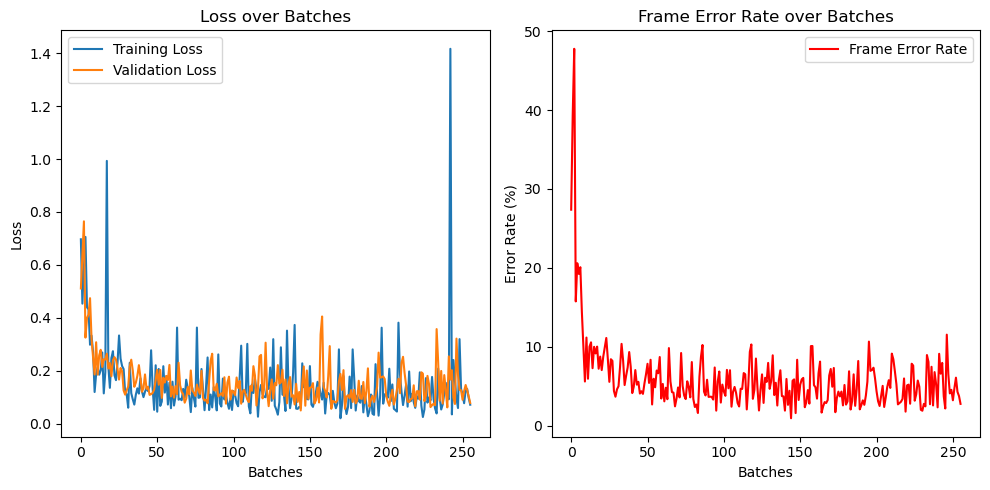

In [165]:
trainer = LinearProbeTrainer(model=classifier_model, train_loader=train_loader, test_loader=test_loader, device=device, lr=1e-3, plotting=True, batches_per_eval=1, desired_total_batches=5e2, patience=15)
trainer.train()

## Analyze

Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.71batch/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/test/frame_error_rate_plot.png'

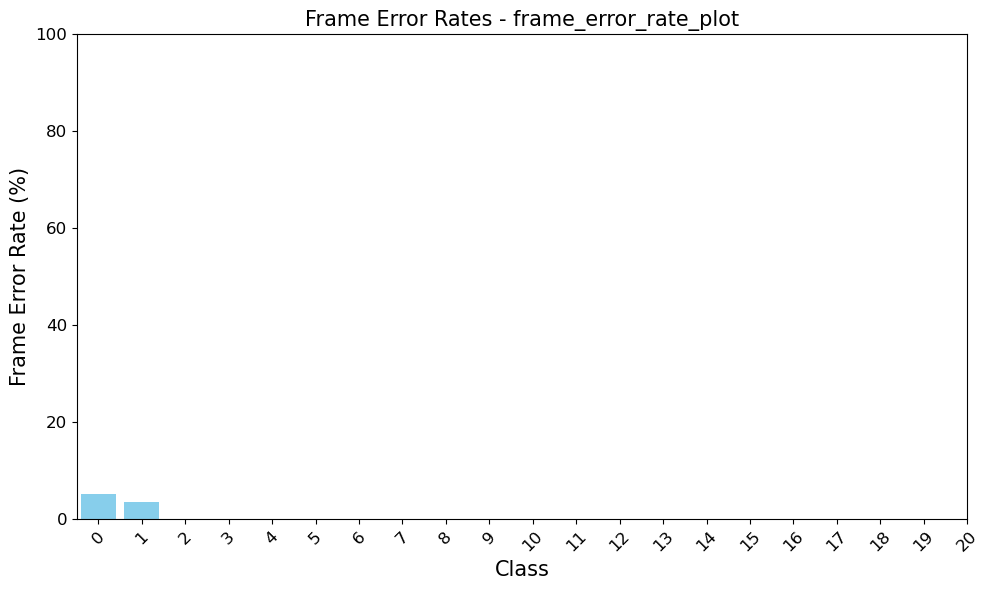

In [166]:
from linear_probe import ModelEvaluator

evaluator = ModelEvaluator(classifier_model, test_loader)
class_frame_error_rates, total_frame_error_rate = evaluator.validate_model_multiple_passes(num_passes=1, max_batches=1250)
evaluator.save_results(class_frame_error_rates, total_frame_error_rate, '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/test')

## Visualize Song and Not Song

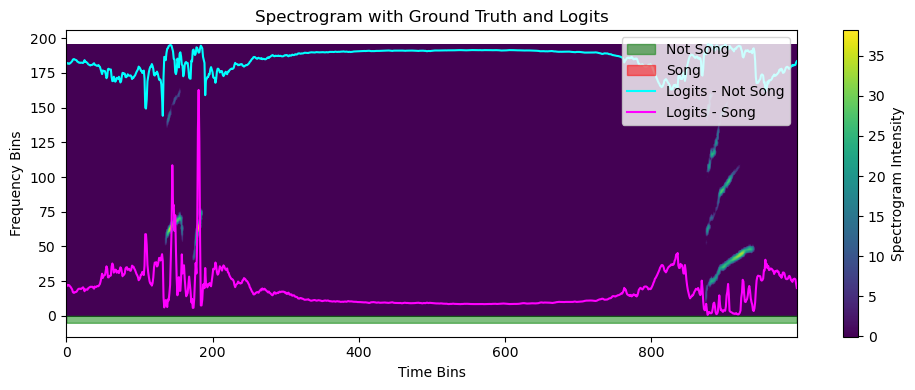

In [173]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def plot_spectrogram_with_labels_and_logits(spec, ground_truth_label, logits):
    # Apply sigmoid to logits to scale them between 0 and 1
    logits_sigmoid = sigmoid(logits.numpy())

    # Scale logits to match the frequency axis of the spectrogram
    freq_range = spec.shape[0]  # Assuming the frequency range is the first dimension of spec
    logits_scaled = logits_sigmoid * freq_range  # Scale the logits to the spectrogram's frequency range

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot spectrogram
    plt.imshow(spec.numpy(), aspect='auto', origin='lower')

    # Overlay ground truth labels as a bar
    song_bar = ground_truth_label.numpy()[:, 0]  # Assuming first column is for 'song'
    not_song_bar = ground_truth_label.numpy()[:, 1]  # Assuming second column is for 'not song'
    plt.fill_between(range(spec.shape[1]), -5, 0, where=song_bar > 0.5, color='green', step='mid', alpha=0.5, label='Not Song')
    plt.fill_between(range(spec.shape[1]), -5, 0, where=not_song_bar > 0.5, color='red', step='mid', alpha=0.5, label='Song')

    # Overlay logits as line plots
    # Note: We add a small offset to avoid plotting directly on the bottom axis
    plt.plot(logits_scaled[:, 0], color='cyan', label='Logits - Not Song')
    plt.plot(logits_scaled[:, 1], color='magenta', label='Logits - Song')

    plt.colorbar(label='Spectrogram Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Spectrogram with Ground Truth and Logits')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


spec, ground_truth_label, _ = next(iter(test_loader))


logits = classifier_model.forward(spec.to(device))

# first batch 
spec = spec[0]
ground_truth_label = ground_truth_label[0]
logits = logits[0]

# remove channel dims
spec = spec[0]
# Example usage with your data (convert tensors to CPU if on a different device)
plot_spectrogram_with_labels_and_logits(spec.detach().cpu(), ground_truth_label.detach().cpu(), logits.detach().cpu())


In [174]:
import os

src = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/sort_these"

files_iterator = iter(os.listdir(src))  # Create an iterator over the files


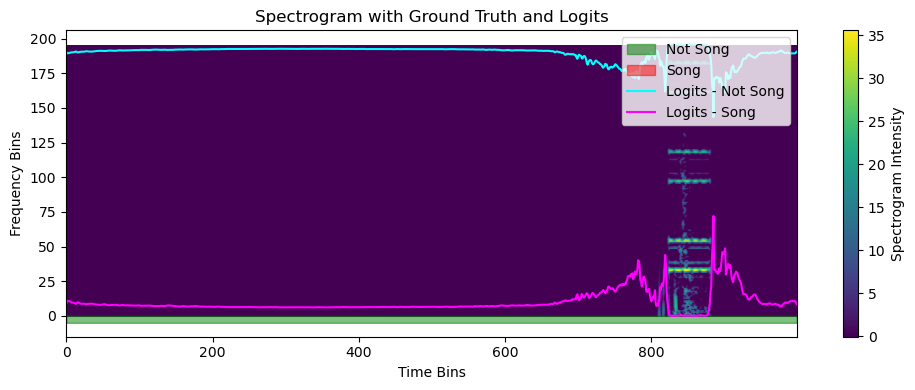

In [212]:
import numpy as np
import torch

# Ensure to run this part only after initializing `files_iterator` as shown above

try:
    file = next(files_iterator)  # Get the next file from the iterator
    file_path = os.path.join(src, file)  # Full path to the file

    # Load the spectrogram from the file
    f = np.load(file_path, allow_pickle=True)
    spec = f['s']
    # spec = spec[20:216]  # Trimming the spectrogram

    # Z-score normalization
    spec_mean = spec.mean()
    spec_std = spec.std()
    spec = (spec - spec_mean) / spec_std

    # Forward pass through the model (assuming `classifier_model` and `device` are already defined)
    logits = classifier_model.forward(torch.Tensor(spec[:,:1000]).unsqueeze(0).unsqueeze(0).to(device))
    logits = logits[0]

    # Assuming `plot_spectrogram_with_labels_and_logits` and `ground_truth_label` are defined
    plot_spectrogram_with_labels_and_logits(torch.Tensor(spec[:,:1000]), ground_truth_label.detach().cpu(), logits.detach().cpu())

except StopIteration:
    print("No more files to process.")


In [213]:
import os
import numpy as np
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

# Assuming `classifier_model` and `device` are already defined

def process_spectrogram(spec, max_length=1000):
    """
    Process the spectrogram in chunks, pass through the classifier, and return the combined logits.
    """
    # Calculate the number of chunks needed
    num_chunks = int(np.ceil(spec.shape[1] / max_length))
    combined_logits = []

    for i in range(num_chunks):
        # Extract the chunk
        start_idx = i * max_length
        end_idx = min((i + 1) * max_length, spec.shape[1])
        chunk = spec[:, start_idx:end_idx]

        # Forward pass through the model
        logits = classifier_model.forward(torch.Tensor(chunk).unsqueeze(0).unsqueeze(0).to(device))
        logits = logits[0]

        # Convert logits to binary predictions
        binary_logits = (logits[:, 1] > logits[:, 0]).long()

        # Append the binary logits
        combined_logits.append(binary_logits.detach().cpu().numpy())

    # Concatenate all chunks' logits
    final_logits = np.concatenate(combined_logits, axis=-1)

    return final_logits

def process_files(src):
    """
    Process each file in the directory, reshape logits, and overwrite the original files with the processed data.
    """
    files = os.listdir(src)
    for file in tqdm(files, desc="Processing files"):  # Wrap the loop with tqdm for progress tracking
        file_path = os.path.join(src, file)

        try:
            # Load the spectrogram from the file
            f = np.load(file_path, allow_pickle=True)
            spec = f['s']

             # Z-score normalization
            spec_mean = spec.mean()
            spec_std = spec.std()
            spec = (spec - spec_mean) / spec_std


            # Process the spectrogram and get logits
            logits = process_spectrogram(spec)

            # Overwrite the original file with the spectrogram and logits
            np.savez(file_path, s=spec, song=logits)  # Use the original `file_path` to overwrite

        except Exception as e:
            print(f"Failed to process file {file}: {str(e)}")

src = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/sort_these"
process_files(src)


Processing files:   0%|          | 0/25194 [00:00<?, ?it/s]

Processing files:  42%|████▏     | 10601/25194 [14:15<15:57, 15.25it/s] 

Failed to process file USA5185_45214.62448432_10_15_17_20_48.npz: File is not a zip file


Processing files:  94%|█████████▍| 23646/25194 [32:25<01:51, 13.86it/s]  

Failed to process file processed_processed_USA5185_45263.48623492_12_3_13_30_23.npz: EOF: reading array data, expected 262144 bytes got 0


Processing files: 100%|██████████| 25194/25194 [34:55<00:00, 12.02it/s]


KeyboardInterrupt: 

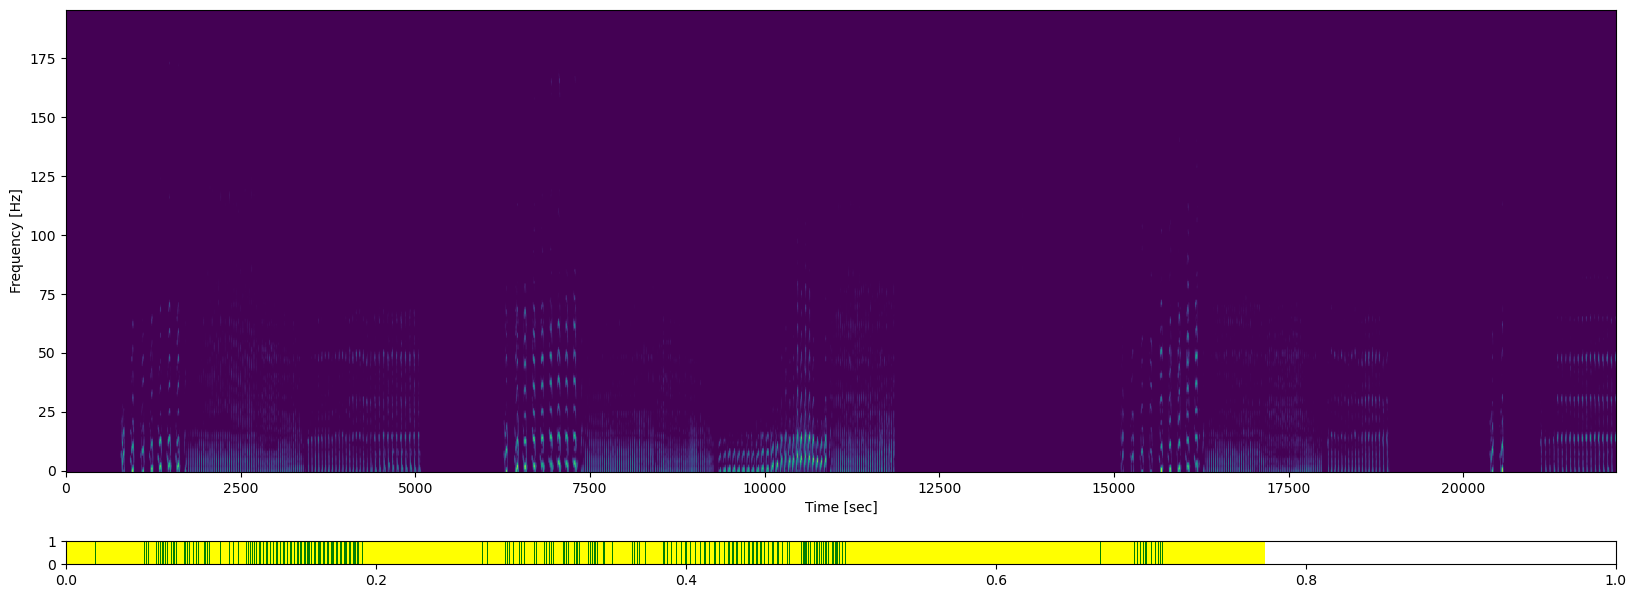

: 

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter

def majority_vote(signal, window_size, stride):
    output = np.zeros(len(signal) // stride)
    for i in range(0, len(signal) - window_size + 1, stride):
        window = signal[i:i + window_size]
        most_common = Counter(window).most_common(1)[0][0]
        output[i // stride] = most_common
    return output

src = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/files/sort_these"
output_dir = "/home/george-vengrovski/Documents/projects/tweety_bert_paper/song_detection_images"

# Ensure output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

files = os.listdir(src)

for file_name in files:
    file_path = os.path.join(src, file_name)
    f = np.load(file=file_path, allow_pickle=True)

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.imshow(f['s'], aspect='auto', origin='lower')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')

    # Original signal bar
    original_bar_height = 0.05
    original_bar_y_offset = -0.2
    original_bar_ax = ax.inset_axes([0, original_bar_y_offset, 1, original_bar_height], transform=ax.transAxes)

    for i, value in enumerate(f['song']):
        color = 'green' if value == 1.0 else 'yellow'  # Adjust colors as needed
        original_bar_ax.axvline(x=i/len(f['song']), color=color, linewidth=(fig.get_figwidth() * 72 * original_bar_height))

    original_bar_ax.set_xlim(0, 1)
    original_bar_ax.axis('off')

    # Majority vote signal bar
    majority_vote_array = majority_vote(f['song'], 250, 100)  # Perform majority vote
    majority_bar_height = 0.05
    majority_bar_y_offset = -0.25
    majority_bar_ax = ax.inset_axes([0, majority_bar_y_offset, 1, majority_bar_height], transform=ax.transAxes)

    for i, vote in enumerate(majority_vote_array):
        color = 'red' if vote == 1.0 else 'blue'  # Adjust colors as needed
        majority_bar_ax.axvline(x=i/len(majority_vote_array), color=color, linewidth=(fig.get_figwidth() * 72 * majority_bar_height))

    majority_bar_ax.set_xlim(0, 1)
    majority_bar_ax.axis('off')

    # Save the figure with 'bbox_inches' set to 'tight'
    output_file_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_detection.png")
    plt.savefig(output_file_path, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory
